Upload project_archive.zip file first

--- Successfully extracted files from project_archive.zip ---
--- Loading preprocessed data for SHAP analysis... ---
--- Data loaded successfully. ---
--- Loading final model from fl-tabular/final_model_fedprox.pkl... ---
--- Model loaded successfully. ---

Calculating SHAP values... (this may take a moment)


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.7.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.7.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OneHotEncoder from version 1.7.1 when using version 1.6.1. This might lead to breaking code or invalid r

  0%|          | 0/50 [00:00<?, ?it/s]


--- SHAP Summary Plot ---


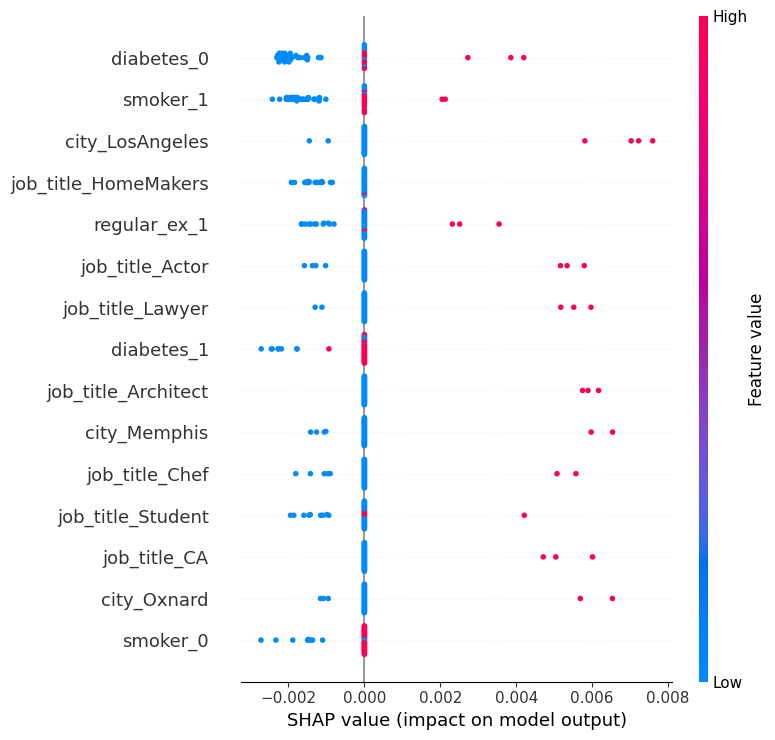

In [4]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import pickle
import shap
import zipfile
from collections import OrderedDict
import matplotlib.pyplot as plt

# --- 1. Unzip the project archive to access necessary files ---
zip_path = 'project_archive.zip'
extract_path = '.' # Extract to the current directory

try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"--- Successfully extracted files from {zip_path} ---")
except FileNotFoundError:
    print(f"Error: Could not find '{zip_path}'. Please upload it to your Colab session.")
    # Exit if the zip file isn't available
    exit()

# --- 2. Define the Model Class and Helper Function ---
class Autoencoder(nn.Module):
    def __init__(self, input_dim: int):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(128, 64), nn.BatchNorm1d(64), nn.ReLU(), nn.Dropout(0.4)
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128), nn.BatchNorm1d(128), nn.ReLU(),
            nn.Linear(128, input_dim)
        )
    def forward(self, x):
        return self.decoder(self.encoder(x))

def set_weights(net, parameters):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

# --- 3. Load Preprocessed Data ---
print("--- Loading preprocessed data for SHAP analysis... ---")
pkl_path = 'fl-tabular/preprocessed_unsupervised.pkl'
model_path = "fl-tabular/final_model_fedprox.pkl"

try:
    with open(pkl_path, "rb") as f:
        processed_data = pickle.load(f)

    X_train_scaled = processed_data["X_train_scaled"]
    X_test_scaled = processed_data["X_test_scaled"]
    feature_names = processed_data["columns"]
    input_dim = processed_data["input_dim"]

    print("--- Data loaded successfully. ---")
except FileNotFoundError:
    print(f"Error: '{pkl_path}' not found inside the zip. Please ensure it was created and zipped correctly.")
    exit()

# --- 4. Load the Final Federated Model ---
print(f"--- Loading final model from {model_path}... ---")
try:
    with open(model_path, "rb") as f:
        final_weights = pickle.load(f)

    model = Autoencoder(input_dim)
    set_weights(model, final_weights)
    model.eval()
    print("--- Model loaded successfully. ---")
except FileNotFoundError:
    print(f"Error: '{model_path}' not found inside the zip. Please upload the correct zip file.")
    exit()

# --- 5. Create the SHAP Explainer ---
def predict_fn(x):
    model.eval()
    x_tensor = torch.from_numpy(x).float()
    with torch.no_grad():
        reconstructions = model(x_tensor)
        errors = torch.mean((x_tensor - reconstructions)**2, axis=1)
    return errors.numpy()

background_summary = shap.sample(X_train_scaled, 100)
explainer = shap.KernelExplainer(predict_fn, background_summary)

# --- 6. Calculate and Plot SHAP Values ---
sample_to_explain = shap.sample(X_test_scaled, 50)
print("\nCalculating SHAP values... (this may take a moment)")
shap_values = explainer.shap_values(sample_to_explain)

print("\n--- SHAP Summary Plot ---")
shap.summary_plot(
    shap_values,
    sample_to_explain,
    feature_names=feature_names,
    max_display=15,
    show=False
)
plt.show()